In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Algoritmos de Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import IsolationForest

# Métricas de Evaluación
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples

# Reducción de dimensionalidad para visualización
from sklearn.decomposition import PCA
# Dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

**CARGA Y TRATAMIENTO INICIAL DE DATOS**

In [ ]:
# Cargar datos
df = pd.read_csv('df_proyectos.csv', encoding='latin-1')
print(f"Cargado: df tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
print(df.head())

Cargado: df tiene 320 filas y 17 columnas.
       cui       fecha                                        lugar  \
0  2152468  21/07/2025                           MARISCAL LUZURIAGA   
1  2372375  01/09/2025                          SOCABAYA - AREQUIPA   
2        3  01/11/2025  CALLAYUC Y SANTA CRUZ - CUTERVO - CAJAMARCA   
3  2517099  01/06/2025              SANTA MARIA DEL VALLE - HUANUCO   
4  2300534  21/03/2025            CHINCHO - ANGARAES - HUANCAVELICA   

   mano_de_obra   materiales     equipos  sub_contratos  costo_directo  \
0    2063761.17   3370047.17   379055.60     1292046.25     7104910.19   
1     268963.17    475490.22    39976.60           0.00      784429.99   
2    5836886.37  11618250.11  2076720.86      135590.00    19667447.34   
3    1475421.16   1729265.08   176263.00       72068.66     3453017.90   
4     915626.98   1737571.63   159461.70           0.00     2812660.31   

   obras_provisionales  estructuras  arquitectura  inst_sanitarias  \
0           164

In [3]:
# Extraer mes de la fecha
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
df['mes'] = df['fecha'].dt.month

# Ratios sobre costo_directo
campos_costo_directo = ['mano_de_obra', 'materiales', 'equipos', 'sub_contratos',
                        'obras_provisionales', 'estructuras', 'arquitectura', 
                        'inst_sanitarias', 'inst_electricas_y_comunicaciones',
                        'otros', 'gastos_generales', 'utilidad', 'sub_total']
for campo in campos_costo_directo:
    nuevo_campo = f'ratio_{campo}_cd'
    df[nuevo_campo] = df[campo] / df['costo_directo']

print(f"df tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
print(df.head())

df tiene 320 filas y 31 columnas.
       cui      fecha                                        lugar  \
0  2152468 2025-07-21                           MARISCAL LUZURIAGA   
1  2372375 2025-09-01                          SOCABAYA - AREQUIPA   
2        3 2025-11-01  CALLAYUC Y SANTA CRUZ - CUTERVO - CAJAMARCA   
3  2517099 2025-06-01              SANTA MARIA DEL VALLE - HUANUCO   
4  2300534 2025-03-21            CHINCHO - ANGARAES - HUANCAVELICA   

   mano_de_obra   materiales     equipos  sub_contratos  costo_directo  \
0    2063761.17   3370047.17   379055.60     1292046.25     7104910.19   
1     268963.17    475490.22    39976.60           0.00      784429.99   
2    5836886.37  11618250.11  2076720.86      135590.00    19667447.34   
3    1475421.16   1729265.08   176263.00       72068.66     3453017.90   
4     915626.98   1737571.63   159461.70           0.00     2812660.31   

   obras_provisionales  estructuras  ...  ratio_sub_contratos_cd  \
0           1649648.37   2970743

**ENTENDIMIENTO DE LOS DATOS**

In [4]:
# Tipos de variables
print(f"Tipos de datos:")
print(df.dtypes)

# Clasificación de variables
vars_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
vars_categoricas = df.select_dtypes(include=['object']).columns.tolist()
vars_datetime = df.select_dtypes(include=['datetime64']).columns.tolist()

print(f"Clasificación de variables:")
print(f" - Variables numéricas: {len(vars_numericas)}")
print(f" - Variables categóricas: {len(vars_categoricas)}")
print(f" - Variables de fecha: {len(vars_datetime)}")

Tipos de datos:
cui                                                   int64
fecha                                        datetime64[ns]
lugar                                                object
mano_de_obra                                        float64
materiales                                          float64
equipos                                             float64
sub_contratos                                       float64
costo_directo                                       float64
obras_provisionales                                 float64
estructuras                                         float64
arquitectura                                        float64
inst_sanitarias                                     float64
inst_electricas_y_comunicaciones                    float64
otros                                               float64
gastos_generales                                    float64
utilidad                                            float64
sub_total               

Variables con valores faltantes:
                                 Variable  Valores_Faltantes  Porcentaje_%
             ratio_obras_provisionales_cd                 31          9.69
                          inst_sanitarias                 29          9.06
                 ratio_inst_sanitarias_cd                 29          9.06
                      obras_provisionales                 28          8.75
         inst_electricas_y_comunicaciones                 23          7.19
                              estructuras                 23          7.19
                    ratio_arquitectura_cd                 23          7.19
                     ratio_estructuras_cd                 23          7.19
                             arquitectura                 23          7.19
ratio_inst_electricas_y_comunicaciones_cd                 23          7.19
                           ratio_otros_cd                 16          5.00
                                    otros                 13       

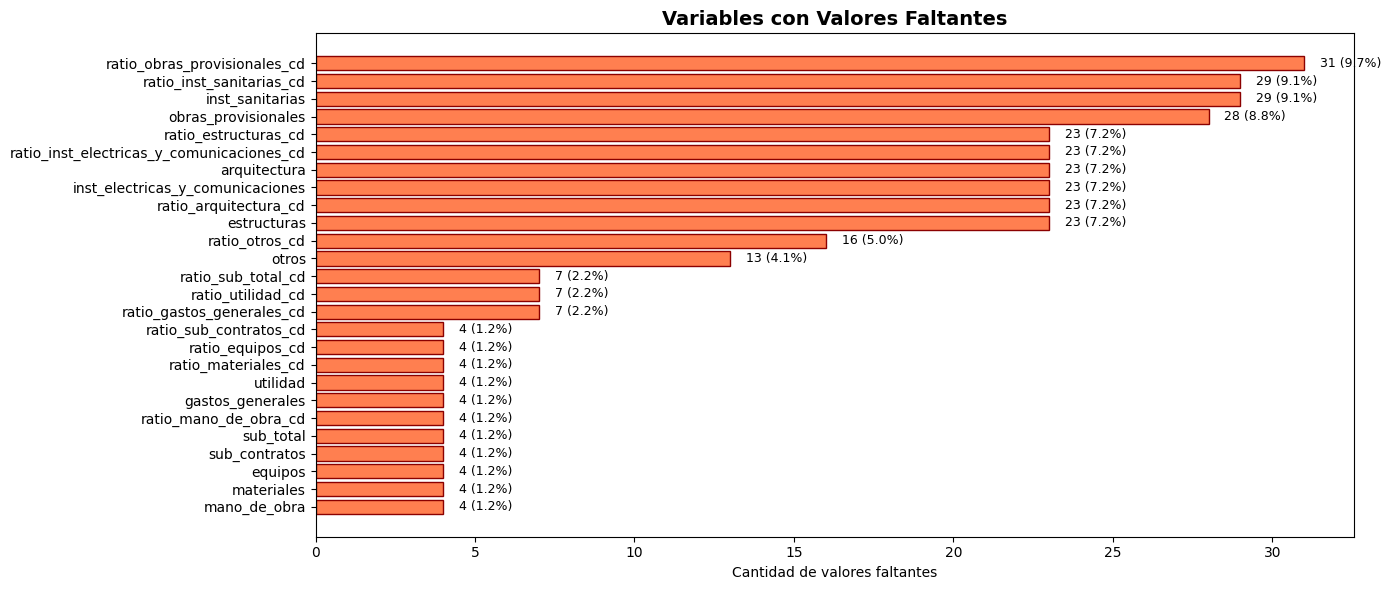

In [5]:
# Análisis de valores faltantes
valores_faltantes = df.isnull().sum()
porcentaje_faltantes = (df.isnull().sum() / len(df) * 100).round(2)
df_faltantes = pd.DataFrame({
    'Variable': valores_faltantes.index,
    'Valores_Faltantes': valores_faltantes.values,
    'Porcentaje_%': porcentaje_faltantes.values
})
df_faltantes = df_faltantes[df_faltantes['Valores_Faltantes'] > 0].sort_values('Porcentaje_%', ascending=False)

print("Variables con valores faltantes:")
if len(df_faltantes) > 0:
    print(df_faltantes.to_string(index=False))
else:
    print("No hay valores faltantes en el dataset")

# Visualización de valores faltantes
fig, ax = plt.subplots(figsize=(14, 6))
valores_nulos = df.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=True)
if len(valores_nulos) > 0:
    bars = ax.barh(valores_nulos.index, valores_nulos.values, color='coral', edgecolor='darkred')
    ax.set_xlabel('Cantidad de valores faltantes')
    ax.set_title('Variables con Valores Faltantes', fontsize=14, fontweight='bold')
    for bar, val in zip(bars, valores_nulos.values):
        ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val} ({val/len(df)*100:.1f}%)', 
                va='center', fontsize=9)
plt.tight_layout()
plt.savefig('01_valores_faltantes.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

In [6]:
# Estadísticas descriptivas

# Variables financieras principales
vars_financieras_1 = ['mano_de_obra', 'materiales', 'equipos', 'sub_contratos']
vars_financieras_1 = [v for v in vars_financieras_1 if v in df.columns]
print("Estadísticas de variables financieras principales 1:")
stats_financieras = df[vars_financieras_1].describe()
print(stats_financieras.to_string())

# Variables financieras principales
vars_financieras_2 = ['obras_provisionales', 'estructuras', 'arquitectura', 'inst_sanitarias', 'inst_electricas_y_comunicaciones', 'otros']
vars_financieras_2 = [v for v in vars_financieras_2 if v in df.columns]
print("Estadísticas de variables financieras principales 2:")
stats_financieras = df[vars_financieras_2].describe()
print(stats_financieras.to_string())

# Variables financieras principales
vars_financieras_3 = ['costo_directo', 'gastos_generales', 'utilidad', 'sub_total']
vars_financieras_3 = [v for v in vars_financieras_3 if v in df.columns]
print("Estadísticas de variables financieras principales 3:")
stats_financieras = df[vars_financieras_3].describe()
print(stats_financieras.to_string())

# Variables de ratios
vars_ratios = [col for col in df.columns if col.startswith('ratio_')]
print(f"Estadísticas de variables de ratios:")
stats_ratios = df[vars_ratios].describe()
print(stats_ratios.to_string())

Estadísticas de variables financieras principales 1:
       mano_de_obra    materiales       equipos  sub_contratos
count  3.160000e+02  3.160000e+02  3.160000e+02   3.160000e+02
mean   2.776503e+06  5.468133e+06  6.854961e+05   4.172198e+05
std    3.217555e+06  6.593267e+06  1.156977e+06   8.638073e+05
min    0.000000e+00  0.000000e+00  1.117698e+04   0.000000e+00
25%    5.229490e+05  9.612428e+05  9.142875e+04   5.025000e+02
50%    1.533774e+06  2.814947e+06  2.552753e+05   7.499696e+04
75%    3.955204e+06  6.760905e+06  5.913785e+05   3.457349e+05
max    1.923914e+07  3.437670e+07  7.906225e+06   5.319064e+06
Estadísticas de variables financieras principales 2:
       obras_provisionales   estructuras  arquitectura  inst_sanitarias  inst_electricas_y_comunicaciones         otros
count         2.920000e+02  2.970000e+02  2.970000e+02     2.910000e+02                      2.970000e+02  3.070000e+02
mean          1.020910e+06  4.207355e+06  2.546061e+06     3.341617e+05                

Detección de outliers en variables principales:
                                 Variable  N_Outliers Porcentaje
                                    otros          52      16.9%
                                  equipos          49      15.5%
                            sub_contratos          42      13.3%
                           ratio_otros_cd          34      11.2%
                         gastos_generales          34      10.8%
                               materiales          32      10.1%
                     ratio_estructuras_cd          30      10.1%
                              estructuras          29       9.8%
ratio_inst_electricas_y_comunicaciones_cd          28       9.4%
         inst_electricas_y_comunicaciones          27       9.1%
                    ratio_arquitectura_cd          27       9.1%
                                 utilidad          27       8.5%
                            costo_directo          26       8.1%
                                sub_total 

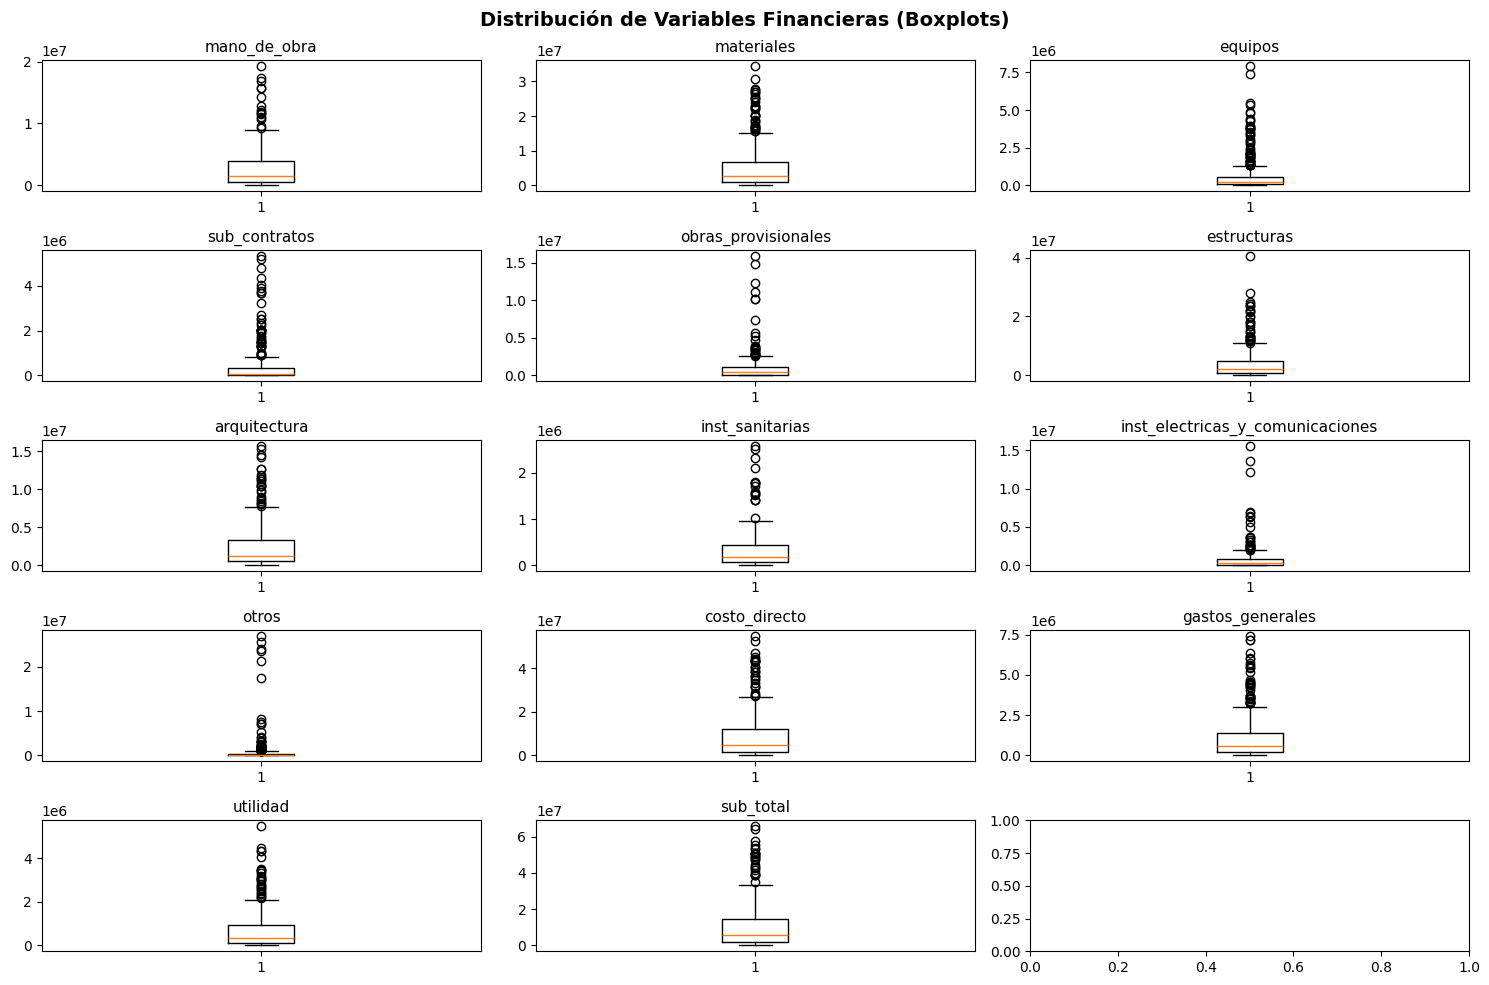

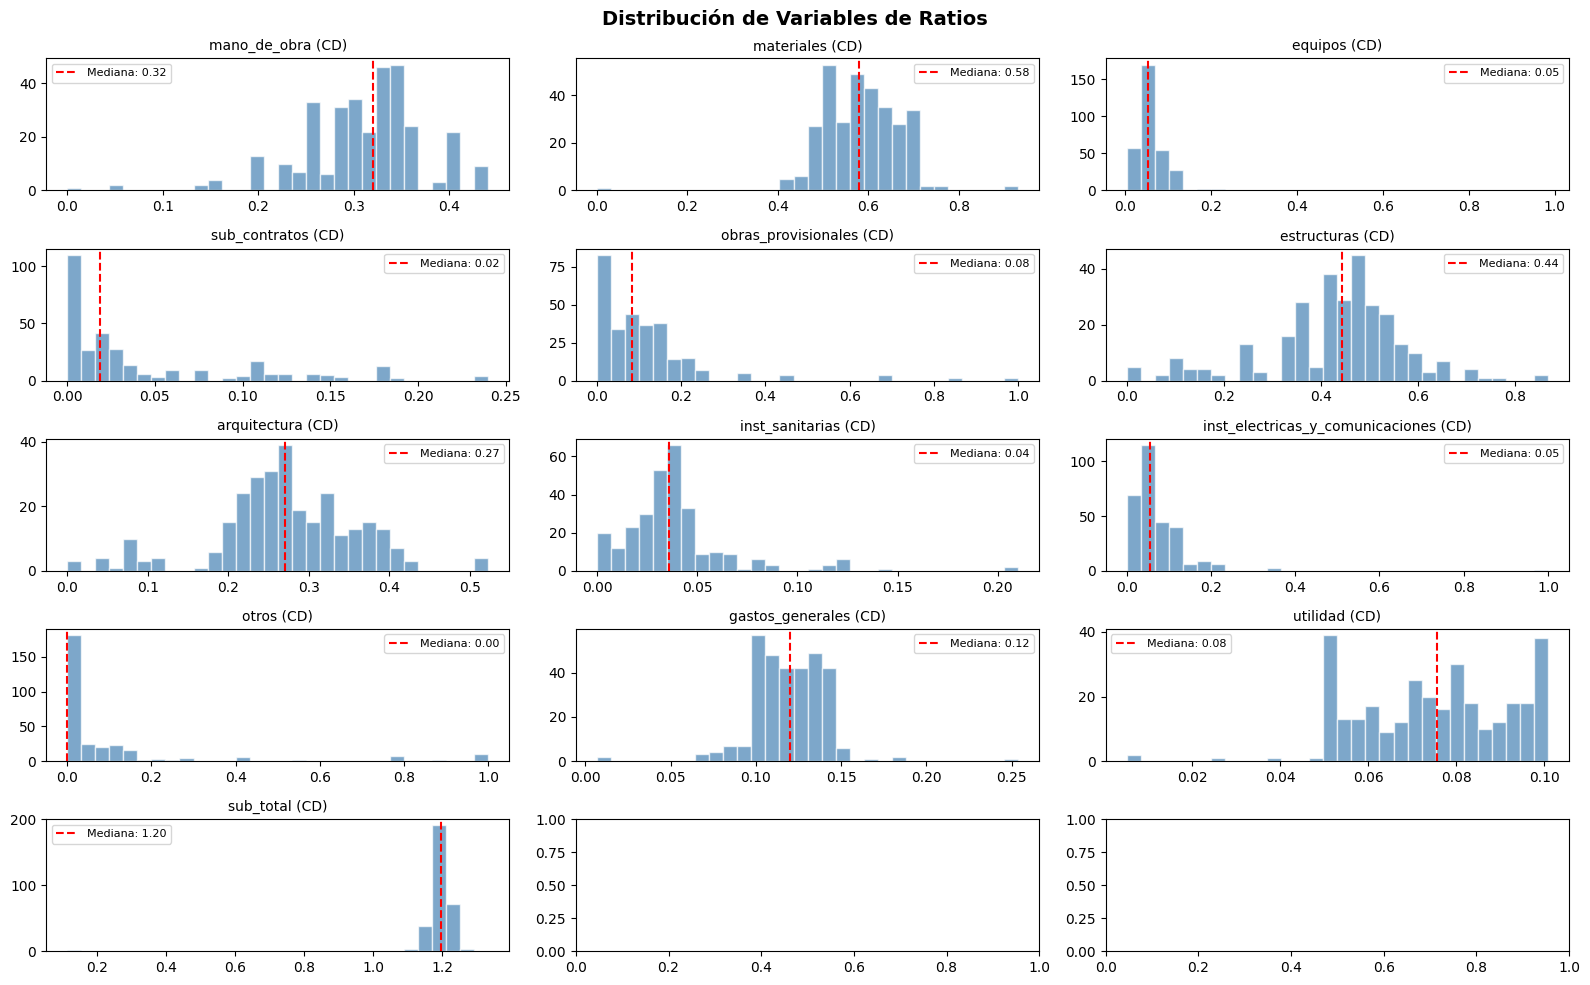

In [7]:
# Análisis de outliers
def detectar_outliers_iqr(serie, nombre):
    """Detecta outliers usando el método del rango intercuartílico"""
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = serie[(serie < limite_inferior) | (serie > limite_superior)]
    return len(outliers), limite_inferior, limite_superior

print("Detección de outliers en variables principales:")
outliers_info = []
for var in vars_financieras_1 + vars_financieras_2 + vars_financieras_3 + vars_ratios:
    if var in df.columns:
        serie = df[var].dropna()
        n_outliers, lim_inf, lim_sup = detectar_outliers_iqr(serie, var)
        pct_outliers = (n_outliers / len(serie) * 100) if len(serie) > 0 else 0
        outliers_info.append({
            'Variable': var,
            'N_Outliers': n_outliers,
            'Porcentaje': f'{pct_outliers:.1f}%'
        })

df_outliers = pd.DataFrame(outliers_info)
df_outliers = df_outliers[df_outliers['N_Outliers'] > 0].sort_values('N_Outliers', ascending=False)
print(df_outliers.head(15).to_string(index=False))

# Visualización de distribuciones
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
vars_plot = ['mano_de_obra', 'materiales', 'equipos', 'sub_contratos',
            'obras_provisionales', 'estructuras', 'arquitectura', 
            'inst_sanitarias', 'inst_electricas_y_comunicaciones',
            'otros', 'costo_directo', 'gastos_generales', 'utilidad', 'sub_total']
for i, var in enumerate(vars_plot):
    ax = axes[i//3, i%3]
    data = df[var].dropna()
    ax.boxplot(data, vert=True)
    ax.set_title(f'{var}', fontsize=11)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.suptitle('Distribución de Variables Financieras (Boxplots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('02_boxplots_financieras.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# Distribución de ratios
fig, axes = plt.subplots(5, 3, figsize=(16, 10))
axes = axes.flatten()
for i, var in enumerate(vars_ratios):
    data = df[var].dropna()
    data = data[np.isfinite(data)]  # Eliminar inf
    if len(data) > 0:
        axes[i].hist(data, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
        axes[i].set_title(var.replace('ratio_', '').replace('_cd', ' (CD)'), fontsize=10)
        axes[i].axvline(data.median(), color='red', linestyle='--', label=f'Mediana: {data.median():.2f}')
        axes[i].legend(fontsize=8)
plt.suptitle('Distribución de Variables de Ratios', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('03_histogramas_ratios.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

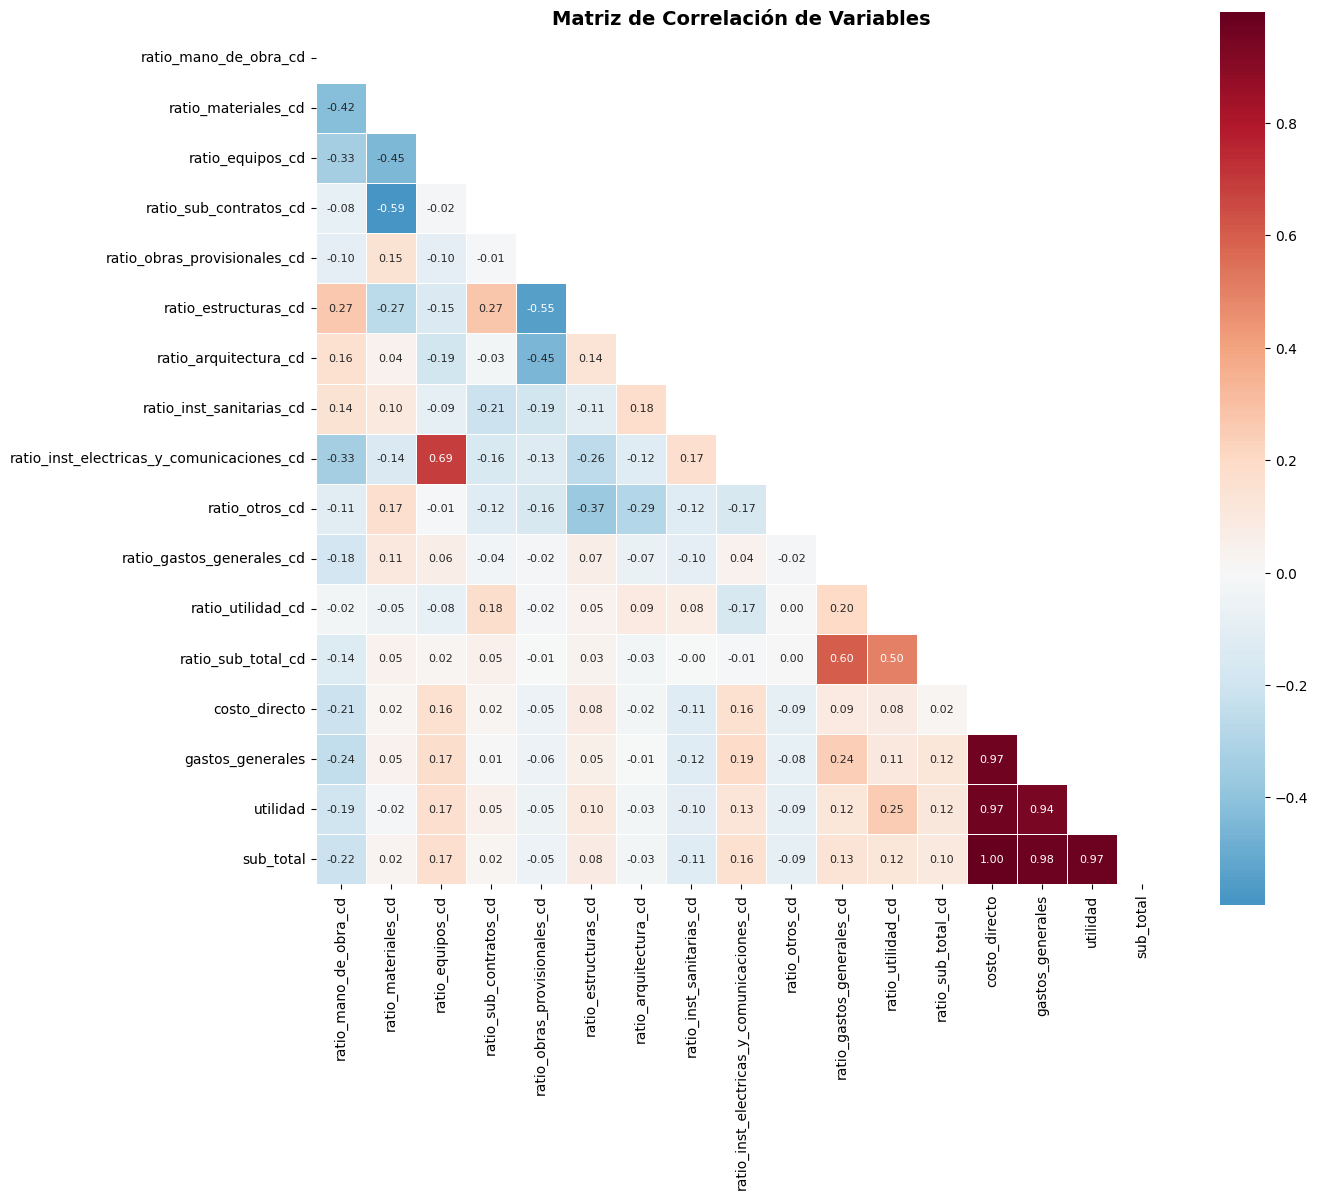

Correlaciones altas (|r| > 0.7):
      Variable 1       Variable 2 Correlación
   costo_directo gastos_generales       0.970
   costo_directo         utilidad       0.968
   costo_directo        sub_total       0.997
gastos_generales         utilidad       0.945
gastos_generales        sub_total       0.978
        utilidad        sub_total       0.974


In [8]:
# Análisis de correlaciones

# Matriz de correlación para ratios
vars_para_corr = vars_ratios + vars_financieras_3
vars_para_corr = [v for v in vars_para_corr if v in df.columns]
df_corr = df[vars_para_corr].dropna()

# Reemplazar inf por NaN y luego imputar
df_corr = df_corr.replace([np.inf, -np.inf], np.nan)
df_corr = df_corr.dropna()

if len(df_corr) > 0:
    corr_matrix = df_corr.corr()
    
    fig, ax = plt.subplots(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, linewidths=0.5, ax=ax,
                annot_kws={'size': 8})
    ax.set_title('Matriz de Correlación de Variables', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('04_matriz_correlacion.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# Identificar correlaciones altas
print("Correlaciones altas (|r| > 0.7):")
corr_alta = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            corr_alta.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlación': f'{corr_matrix.iloc[i, j]:.3f}'
            })
if corr_alta:
    df_corr_alta = pd.DataFrame(corr_alta)
    print(df_corr_alta.to_string(index=False))

**PREPARACIÓN DE LOS DATOS**

In [10]:
# Crear copia para trabajar
df_trabajo = df.copy()

# Variables seleccionadas para el análisis
vars_modelo = [
    # Ratios sobre costo directo
    'ratio_mano_de_obra_cd',
    'ratio_materiales_cd', 
    'ratio_equipos_cd',
    'ratio_sub_contratos_cd',
    'ratio_obras_provisionales_cd',
    'ratio_estructuras_cd',
    'ratio_arquitectura_cd',
    'ratio_inst_sanitarias_cd',
    'ratio_inst_electricas_y_comunicaciones_cd',
    'ratio_otros_cd',
    'ratio_gastos_generales_cd',
    'ratio_utilidad_cd',
    'ratio_sub_total_cd',
    # Variables de escala
    'costo_directo',
    # Temporal
    'mes'
]

vars_modelo = [v for v in vars_modelo if v in df_trabajo.columns]
print(f"Variables seleccionadas para el modelo ({len(vars_modelo)}):")
for i, var in enumerate(vars_modelo, 1):
    print(f"   {i}. {var}")

Variables seleccionadas para el modelo (15):
   1. ratio_mano_de_obra_cd
   2. ratio_materiales_cd
   3. ratio_equipos_cd
   4. ratio_sub_contratos_cd
   5. ratio_obras_provisionales_cd
   6. ratio_estructuras_cd
   7. ratio_arquitectura_cd
   8. ratio_inst_sanitarias_cd
   9. ratio_inst_electricas_y_comunicaciones_cd
   10. ratio_otros_cd
   11. ratio_gastos_generales_cd
   12. ratio_utilidad_cd
   13. ratio_sub_total_cd
   14. costo_directo
   15. mes


*JUSTIFICACIÓN DE LA SELECCIÓN:*
   - Los RATIOS permiten comparar proyectos independientemente de su tamaño.
   - ratio_*_cd: Muestra la distribución del costo directo entre componentes.
   - costo_directo: Captura la escala del proyecto.
   - mes: Puede revelar patrones estacionales en sobrecostos.
   - Se excluyen variables categóricas (lugar, cui) que no aportan al análisis numérico.
   - Se excluye gastos_generales, utilidad y sub_total por ser derivada y altamente correlacionada.

In [11]:
# Crear DataFrame con solo las variables del modelo
df_modelo = df_trabajo[vars_modelo].copy()

# Reemplazar infinitos por NaN
df_modelo = df_modelo.replace([np.inf, -np.inf], np.nan)

print(f"Valores faltantes antes de imputación:")
print(df_modelo.isnull().sum())

Valores faltantes antes de imputación:
ratio_mano_de_obra_cd                         4
ratio_materiales_cd                           4
ratio_equipos_cd                              4
ratio_sub_contratos_cd                        4
ratio_obras_provisionales_cd                 31
ratio_estructuras_cd                         26
ratio_arquitectura_cd                        26
ratio_inst_sanitarias_cd                     32
ratio_inst_electricas_y_comunicaciones_cd    26
ratio_otros_cd                               16
ratio_gastos_generales_cd                     7
ratio_utilidad_cd                             7
ratio_sub_total_cd                            7
costo_directo                                 0
mes                                           0
dtype: int64


*ESTRATEGIA DE IMPUTACIÓN:*
   - Para RATIOS: Imputar con la MEDIANA (robusta a outliers).
   - Para variables de ESCALA: Imputar con la MEDIANA.
   
   JUSTIFICACIÓN: La mediana es más robusta que la media en presencia
   de outliers, los cuales son frecuentes en datos financieros.

In [12]:
# Imputación por mediana para la mayoría
imputer_mediana = SimpleImputer(strategy='median')
vars_para_imputar_mediana = [v for v in vars_modelo if v != 'mes']

# Imputar
df_modelo[vars_para_imputar_mediana] = imputer_mediana.fit_transform(df_modelo[vars_para_imputar_mediana])

print(f"Valores faltantes después de imputación:")
print(df_modelo.isnull().sum().sum(), "valores faltantes restantes")

Valores faltantes después de imputación:
0 valores faltantes restantes


*ESTRATEGIA DE TRATAMIENTO DE OUTLIERS:*
   - Para el CLUSTERING: Aplicar WINSORIZACIÓN al percentil 1-99.
   - JUSTIFICACIÓN: Los outliers extremos distorsionan las distancias
     en algoritmos como K-Means, pero no queremos eliminar proyectos
     ya que podrían ser precisamente los que tienen sobrecostos.
   - Mantenemos el DataFrame original con outliers para comparar.

In [13]:
# Tratamiento de outliers
 
# Función de winsorización
def winsorize(serie, lower_pct=1, upper_pct=99):
    """Winsoriza una serie al percentil especificado"""
    lower = np.percentile(serie.dropna(), lower_pct)
    upper = np.percentile(serie.dropna(), upper_pct)
    return serie.clip(lower=lower, upper=upper)

# Aplicar winsorización
df_modelo_win = df_modelo.copy()
for var in vars_modelo:
    if var != 'mes':  # No winsorizar el mes
        df_modelo_win[var] = winsorize(df_modelo_win[var])

# Comparar estadísticas antes y después
print(" Comparación de estadísticas (ejemplo: ratio_mano_de_obra_cd):")
print(f"Antes - Min: {df_modelo['ratio_mano_de_obra_cd'].min():.4f}, Max: {df_modelo['ratio_mano_de_obra_cd'].max():.4f}")
print(f"Después - Min: {df_modelo_win['ratio_mano_de_obra_cd'].min():.4f}, Max: {df_modelo_win['ratio_mano_de_obra_cd'].max():.4f}")

# Comparar estadísticas antes y después
print("\n Comparación de estadísticas (ejemplo: ratio_obras_provisionales_cd):")
print(f"Antes - Min: {df_modelo['ratio_obras_provisionales_cd'].min():.4f}, Max: {df_modelo['ratio_obras_provisionales_cd'].max():.4f}")
print(f"Después - Min: {df_modelo_win['ratio_obras_provisionales_cd'].min():.4f}, Max: {df_modelo_win['ratio_obras_provisionales_cd'].max():.4f}")

 Comparación de estadísticas (ejemplo: ratio_mano_de_obra_cd):
Antes - Min: 0.0000, Max: 0.4412
Después - Min: 0.1447, Max: 0.4273

 Comparación de estadísticas (ejemplo: ratio_obras_provisionales_cd):
Antes - Min: 0.0000, Max: 1.0000
Después - Min: 0.0000, Max: 0.8111


*ESTRATEGIAS DE ESCALADO A COMPARAR:*
   1. StandardScaler: Estandariza a media=0, std=1
      - Ventaja: Preserva distribución original
      - Uso: Ideal para K-Means, GMM
   
   2. RobustScaler: Usa mediana y rango intercuartílico
      - Ventaja: Robusto a outliers
      - Uso: Cuando hay valores extremos
   
   3. MinMaxScaler: Escala a rango [0,1]
      - Ventaja: Interpretabilidad
      - Uso: Cuando se necesitan valores acotados
   
   DECISIÓN: Usaremos StandardScaler como principal por su buen
   desempeño general con K-Means y Gaussian Mixture.

In [14]:
# Normalización/Estandarización

# Aplicar diferentes escaladores
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

# DataFrame principal: StandardScaler con datos winzorizados
X_scaled = scaler_standard.fit_transform(df_modelo_win)
df_scaled = pd.DataFrame(X_scaled, columns=vars_modelo, index=df_modelo_win.index)

# Alternativas para comparación
X_robust = scaler_robust.fit_transform(df_modelo_win)
X_minmax = scaler_minmax.fit_transform(df_modelo_win)

print(f"Estadísticas después de escalado:")
print(f"- Media de todas las variables: {X_scaled.mean():.6f}")
print(f"- Desv. estándar promedio: {X_scaled.std(axis=0).mean():.6f}")

Estadísticas después de escalado:
- Media de todas las variables: 0.000000
- Desv. estándar promedio: 1.000000


**CONFIGURACIÓN Y ENTRENAMIENTO DE MODELOS**

1. K-MEANS CLUSTERING

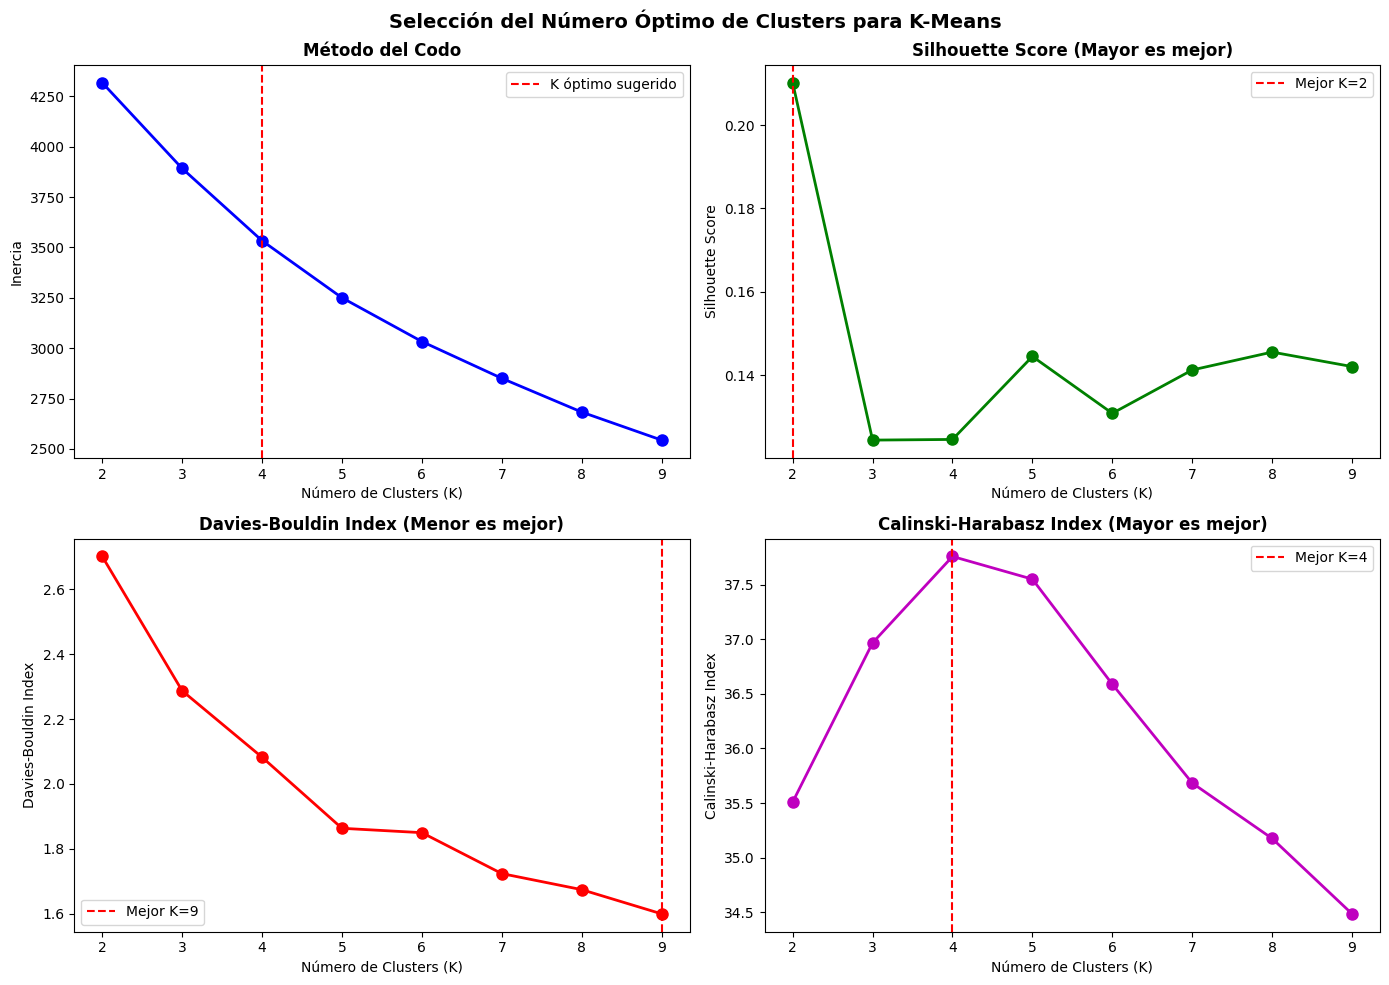

In [15]:
# Determinar número óptimo de clusters
k_range = range(2, 10)
kmeans_results = {'k': [], 'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski': []}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    kmeans_results['k'].append(k)
    kmeans_results['inertia'].append(kmeans.inertia_)
    kmeans_results['silhouette'].append(silhouette_score(X_scaled, labels))
    kmeans_results['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))
    kmeans_results['calinski'].append(calinski_harabasz_score(X_scaled, labels))

# Visualizar métricas para selección de K
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Método del codo
axes[0, 0].plot(kmeans_results['k'], kmeans_results['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Número de Clusters (K)')
axes[0, 0].set_ylabel('Inercia')
axes[0, 0].set_title('Método del Codo', fontweight='bold')
axes[0, 0].axvline(x=4, color='r', linestyle='--', label='K óptimo sugerido')
axes[0, 0].legend()

# Silhouette Score
axes[0, 1].plot(kmeans_results['k'], kmeans_results['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Número de Clusters (K)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Mayor es mejor)', fontweight='bold')
k_mejor_sil = list(kmeans_results['k'])[np.argmax(kmeans_results['silhouette'])]
axes[0, 1].axvline(x=k_mejor_sil, color='r', linestyle='--', label=f'Mejor K={k_mejor_sil}')
axes[0, 1].legend()

# Davies-Bouldin
axes[1, 0].plot(kmeans_results['k'], kmeans_results['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Número de Clusters (K)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Menor es mejor)', fontweight='bold')
k_mejor_db = list(kmeans_results['k'])[np.argmin(kmeans_results['davies_bouldin'])]
axes[1, 0].axvline(x=k_mejor_db, color='r', linestyle='--', label=f'Mejor K={k_mejor_db}')
axes[1, 0].legend()

# Calinski-Harabasz
axes[1, 1].plot(kmeans_results['k'], kmeans_results['calinski'], 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Número de Clusters (K)')
axes[1, 1].set_ylabel('Calinski-Harabasz Index')
axes[1, 1].set_title('Calinski-Harabasz Index (Mayor es mejor)', fontweight='bold')
k_mejor_ch = list(kmeans_results['k'])[np.argmax(kmeans_results['calinski'])]
axes[1, 1].axvline(x=k_mejor_ch, color='r', linestyle='--', label=f'Mejor K={k_mejor_ch}')
axes[1, 1].legend()

plt.suptitle('Selección del Número Óptimo de Clusters para K-Means', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('05_seleccion_k_optimo.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

*JUSTIFICACIÓN DE K=4:*
   - El método del codo sugiere un "quiebre" alrededor de K=3-4-5
   - Silhouette Score máximo en K=2 (0.211)
   - Calinski-Harabasz máximo en K=4
   - Davies-Bouldin mínimo en K=9

   Observamos que 2 de los 4 criterios coinciden en 4 clusters, y Silhouette Score opta por un menor número de cluster, por lo que generaremos opciones al rededor de 4, es decir: 3, 4 y 5 cluster para comparar.

In [16]:
# Entrenar configuraciones
kmeans_configs = {}
for k in [3, 4, 5]:
    name = f'KMeans_K{k}'
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_configs[name] = {'model': model, 'labels': model.fit_predict(X_scaled), 'params': f'K={k}'}

*2. DBSCAN*

Búsqueda de hiperparámetros DBSCAN:
 eps  min_samples  n_clusters  n_noise  pct_noise  silhouette
 1.0            3           7      298    93.1250    0.718272
 2.5            7           2      135    42.1875    0.416345
 1.5            7           2      295    92.1875    0.402005
 1.5            3          16      231    72.1875    0.388745
 1.5            5           5      276    86.2500    0.366486
 2.0            7           3      211    65.9375    0.249511
 3.0            5           4       50    15.6250    0.213557
 2.0           10           2      245    76.5625    0.178976
 3.0            3           8       32    10.0000    0.177132
 2.5            5           7      104    32.5000    0.161037


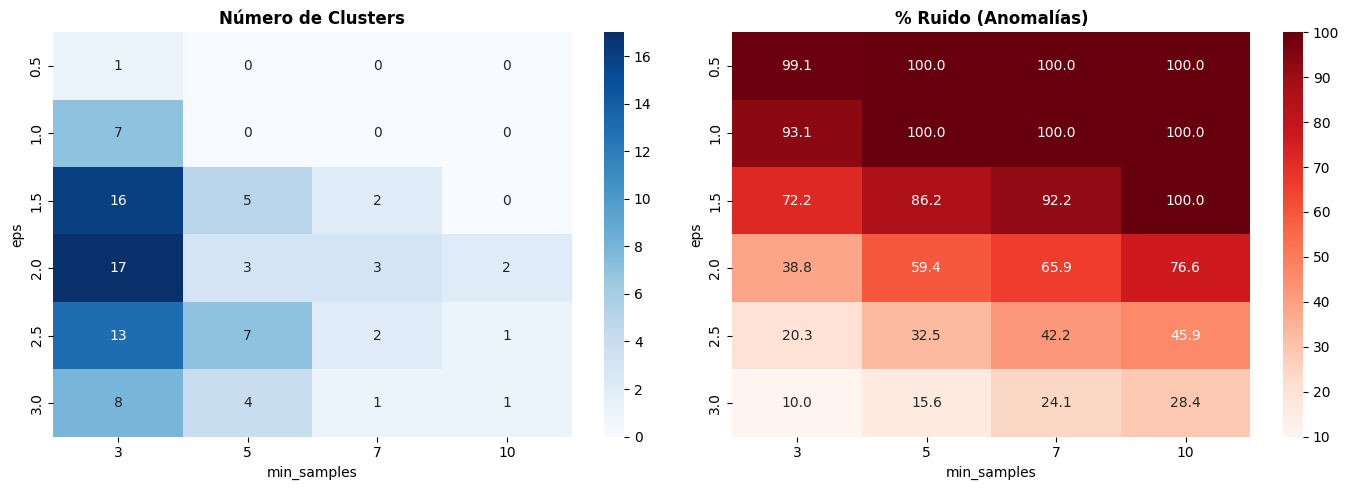

DBSCAN_eps1.5_min5: 5 clusters, 276 ruido (86.2%)
DBSCAN_eps2.0_min5: 3 clusters, 190 ruido (59.4%)
DBSCAN_eps2.5_min3: 13 clusters, 65 ruido (20.3%)
DBSCAN_eps3.0_min5: 4 clusters, 50 ruido (15.6%)


In [17]:
eps_range = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_range = [3, 5, 7, 10]
dbscan_search = []

for eps in eps_range:
    for min_s in min_samples_range:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        sil = -1
        if n_clusters > 1 and (labels != -1).sum() > n_clusters:
            mask = labels != -1
            sil = silhouette_score(X_scaled[mask], labels[mask])
        dbscan_search.append({'eps': eps, 'min_samples': min_s, 'n_clusters': n_clusters, 
                             'n_noise': n_noise, 'pct_noise': n_noise/len(labels)*100, 'silhouette': sil})

df_dbscan = pd.DataFrame(dbscan_search)
print("Búsqueda de hiperparámetros DBSCAN:")
print(df_dbscan[df_dbscan['n_clusters'] >= 1].sort_values('silhouette', ascending=False).head(10).to_string(index=False))

# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pivot_clusters = df_dbscan.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='.0f', cmap='Blues', ax=axes[0])
axes[0].set_title('Número de Clusters', fontweight='bold')
pivot_noise = df_dbscan.pivot(index='eps', columns='min_samples', values='pct_noise')
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='Reds', ax=axes[1])
axes[1].set_title('% Ruido (Anomalías)', fontweight='bold')
plt.tight_layout()
plt.savefig('06_dbscan_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

dbscan_configs = {}
for eps, min_s in [(1.5, 5), (2.0, 5), (2.5, 3), (3.0, 5)]:
    name = f'DBSCAN_eps{eps}_min{min_s}'
    model = DBSCAN(eps=eps, min_samples=min_s)
    labels = model.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    dbscan_configs[name] = {'model': model, 'labels': labels, 'params': f'eps={eps}, min_samples={min_s}',
                           'n_clusters': n_clusters, 'n_noise': n_noise}
    print(f"{name}: {n_clusters} clusters, {n_noise} ruido ({n_noise/len(labels)*100:.1f}%)")


3. CLUSTERING JERÁRQUICO

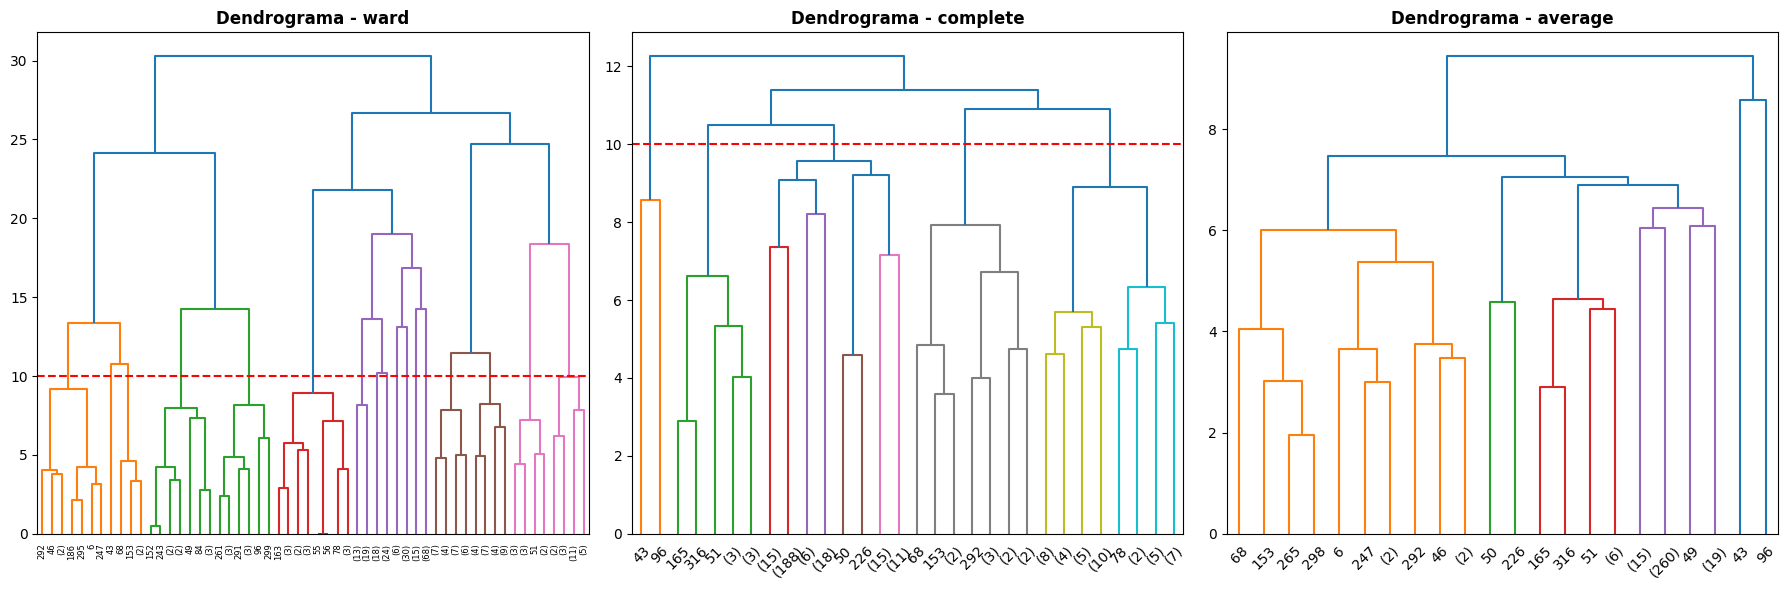

Métricas Clustering Jerárquico:
 linkage  k  silhouette  davies_bouldin  calinski
complete  2    0.446636        1.043326  7.716587
 average  2    0.446636        1.043326  7.716587
 average  3    0.405013        0.426163  5.130091
 average  4    0.320816        0.831413 12.588766
    ward  2    0.290681        2.074349 33.561957
 average  5    0.270806        0.865982 10.749705
 average  6    0.258635        0.891127 13.222754
complete  6    0.166391        1.693462 24.668272
complete  3    0.156029        2.545099 13.080154
    ward  6    0.144521        1.622434 32.838988


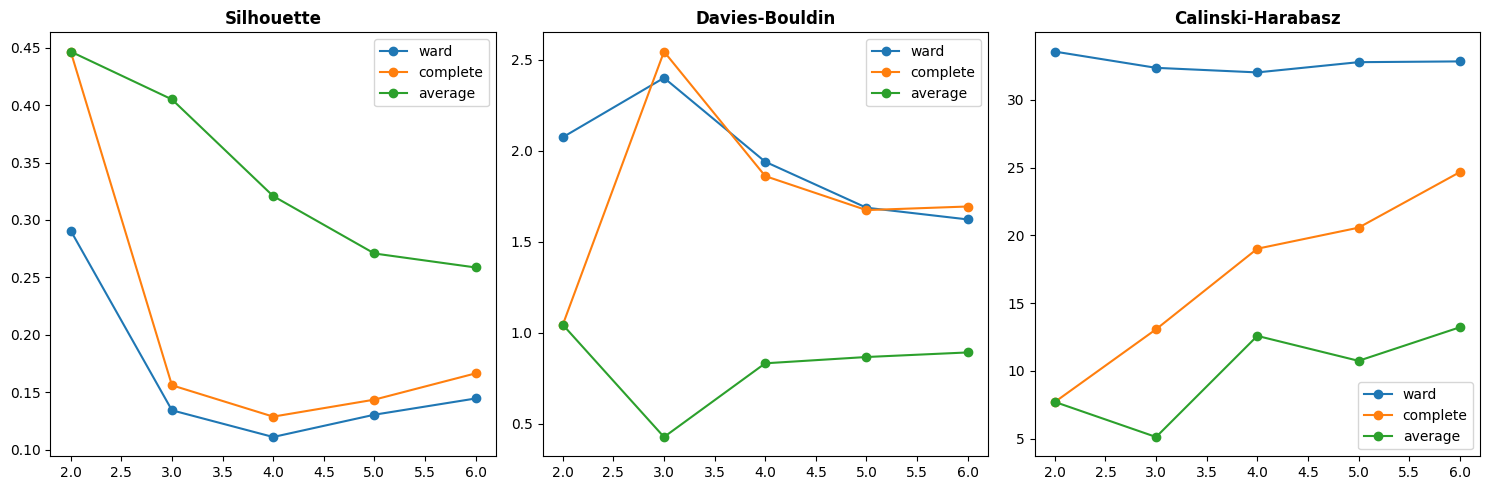

In [18]:
# Dendrogramas
linkage_methods = ['ward', 'complete', 'average']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, method in enumerate(linkage_methods):
    Z = linkage(X_scaled, method=method)
    dendrogram(Z, ax=axes[i], truncate_mode='level', p=5)
    axes[i].set_title(f'Dendrograma - {method}', fontweight='bold')
    axes[i].axhline(y=10, color='r', linestyle='--')
plt.tight_layout()
plt.savefig('07_dendrogramas.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# Evaluar configuraciones
hier_results = []
for method in linkage_methods:
    for k in range(2, 7):
        hier = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = hier.fit_predict(X_scaled)
        hier_results.append({'linkage': method, 'k': k, 
                            'silhouette': silhouette_score(X_scaled, labels),
                            'davies_bouldin': davies_bouldin_score(X_scaled, labels),
                            'calinski': calinski_harabasz_score(X_scaled, labels)})

df_hier = pd.DataFrame(hier_results)
print("Métricas Clustering Jerárquico:")
print(df_hier.sort_values('silhouette', ascending=False).head(10).to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for method in linkage_methods:
    mask = df_hier['linkage'] == method
    axes[0].plot(df_hier[mask]['k'], df_hier[mask]['silhouette'], 'o-', label=method)
    axes[1].plot(df_hier[mask]['k'], df_hier[mask]['davies_bouldin'], 'o-', label=method)
    axes[2].plot(df_hier[mask]['k'], df_hier[mask]['calinski'], 'o-', label=method)
axes[0].set_title('Silhouette', fontweight='bold'); axes[0].legend()
axes[1].set_title('Davies-Bouldin', fontweight='bold'); axes[1].legend()
axes[2].set_title('Calinski-Harabasz', fontweight='bold'); axes[2].legend()
plt.tight_layout()
plt.savefig('08_jerarquico_metricas.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

hier_configs = {}
for method in ['ward', 'complete', 'average']:
    for k in [3, 4]:
        name = f'Hier_{method}_K{k}'
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        hier_configs[name] = {'model': model, 'labels': model.fit_predict(X_scaled), 'params': f'{method}, K={k}'}

4. ISOLATION FOREST

IForest_cont0.05_est100: 16 anomalías (5.0%)
IForest_cont0.05_est150: 16 anomalías (5.0%)
IForest_cont0.1_est100: 32 anomalías (10.0%)
IForest_cont0.1_est150: 32 anomalías (10.0%)
IForest_cont0.15_est100: 48 anomalías (15.0%)
IForest_cont0.15_est150: 48 anomalías (15.0%)
IForest_cont0.2_est100: 64 anomalías (20.0%)
IForest_cont0.2_est150: 64 anomalías (20.0%)


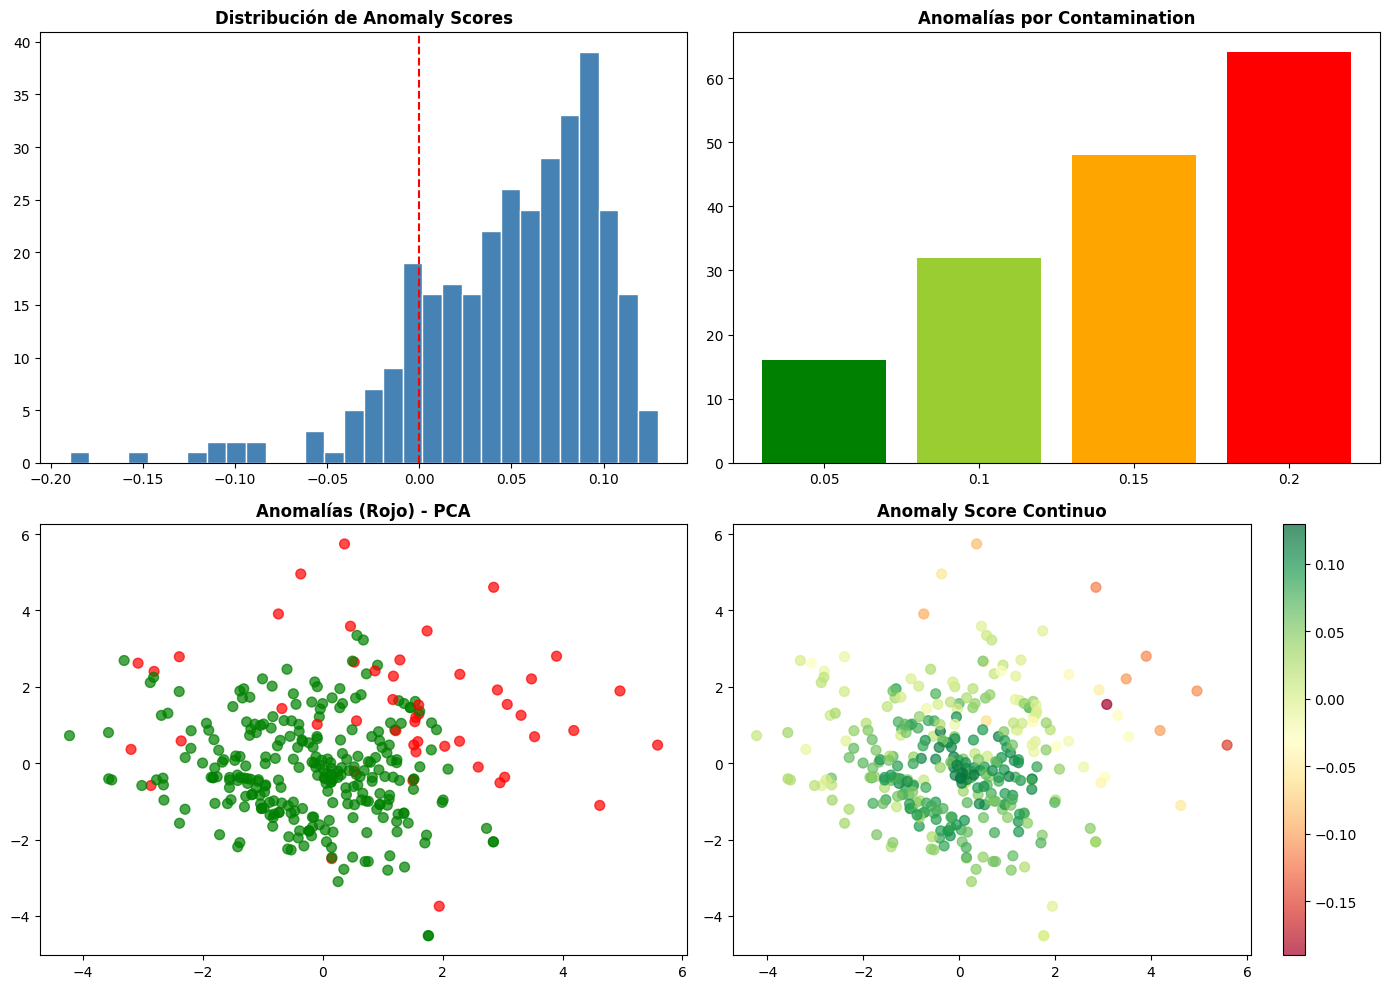

In [19]:
iforest_configs = {}
for cont in [0.05, 0.10, 0.15, 0.20]:
    for n_est in [100, 150]:
        name = f'IForest_cont{cont}_est{n_est}'
        model = IsolationForest(contamination=cont, random_state=42, n_estimators=n_est)
        labels = model.fit_predict(X_scaled)
        scores = model.decision_function(X_scaled)
        n_anom = (labels == -1).sum()
        iforest_configs[name] = {'model': model, 'labels': labels, 'scores': scores,
                                'params': f'cont={cont}, n_est={n_est}', 'n_anomalies': n_anom}
        print(f"{name}: {n_anom} anomalías ({n_anom/len(labels)*100:.1f}%)")

# Visualización IF
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
scores_plot = iforest_configs['IForest_cont0.15_est100']['scores']
labels_plot = iforest_configs['IForest_cont0.15_est100']['labels']

axes[0,0].hist(scores_plot, bins=30, color='steelblue', edgecolor='white')
axes[0,0].axvline(0, color='red', linestyle='--')
axes[0,0].set_title('Distribución de Anomaly Scores', fontweight='bold')

conts = ['0.05', '0.1', '0.15', '0.2']
n_anoms = [iforest_configs[f'IForest_cont{c}_est100']['n_anomalies'] for c in conts]
axes[0,1].bar(conts, n_anoms, color=['green', 'yellowgreen', 'orange', 'red'])
axes[0,1].set_title('Anomalías por Contamination', fontweight='bold')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

colors = ['red' if x == -1 else 'green' for x in labels_plot]
axes[1,0].scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0.7, s=50)
axes[1,0].set_title('Anomalías (Rojo) - PCA', fontweight='bold')

scatter = axes[1,1].scatter(X_pca[:,0], X_pca[:,1], c=scores_plot, cmap='RdYlGn', alpha=0.7, s=50)
plt.colorbar(scatter, ax=axes[1,1])
axes[1,1].set_title('Anomaly Score Continuo', fontweight='bold')

plt.tight_layout()
plt.savefig('09_isolation_forest.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

**EVALUACIÓN DE RESULTADOS**

MÉTRICAS DE EVALUACIÓN:

1. SILHOUETTE SCORE [-1, 1]: Mayor es mejor (cohesión + separación)
2. DAVIES-BOULDIN [0, ∞): Menor es mejor (clusters compactos y separados)
3. CALINSKI-HARABASZ [0, ∞): Mayor es mejor (varianza entre/intra clusters)

In [20]:
# Calcular métricas para todos los modelos
resultados = []

for name, config in kmeans_configs.items():
    resultados.append({'Algoritmo': 'K-Means', 'Modelo': name, 'Params': config['params'],
                      'Silhouette': silhouette_score(X_scaled, config['labels']),
                      'Davies-Bouldin': davies_bouldin_score(X_scaled, config['labels']),
                      'Calinski-Harabasz': calinski_harabasz_score(X_scaled, config['labels'])})

for name, config in dbscan_configs.items():
    if config['n_clusters'] > 1:
        mask = config['labels'] != -1
        if mask.sum() > config['n_clusters']:
            resultados.append({'Algoritmo': 'DBSCAN', 'Modelo': name, 'Params': config['params'],
                              'Silhouette': silhouette_score(X_scaled[mask], config['labels'][mask]),
                              'Davies-Bouldin': davies_bouldin_score(X_scaled[mask], config['labels'][mask]),
                              'Calinski-Harabasz': calinski_harabasz_score(X_scaled[mask], config['labels'][mask])})

for name, config in hier_configs.items():
    resultados.append({'Algoritmo': 'Jerárquico', 'Modelo': name, 'Params': config['params'],
                      'Silhouette': silhouette_score(X_scaled, config['labels']),
                      'Davies-Bouldin': davies_bouldin_score(X_scaled, config['labels']),
                      'Calinski-Harabasz': calinski_harabasz_score(X_scaled, config['labels'])})

In [21]:
df_resultados = pd.DataFrame(resultados)
print("COMPARACIÓN DE TODOS LOS MODELOS:")
print(df_resultados.sort_values('Silhouette', ascending=False).to_string(index=False))

# Mejores modelos
mejor_sil = df_resultados.loc[df_resultados['Silhouette'].idxmax()]
mejor_db = df_resultados.loc[df_resultados['Davies-Bouldin'].idxmin()]
mejor_ch = df_resultados.loc[df_resultados['Calinski-Harabasz'].idxmax()]

print(f"\n MEJORES MODELOS:")
print(f"   Silhouette: {mejor_sil['Modelo']} ({mejor_sil['Silhouette']:.4f})")
print(f"   Davies-Bouldin: {mejor_db['Modelo']} ({mejor_db['Davies-Bouldin']:.4f})")
print(f"   Calinski-Harabasz: {mejor_ch['Modelo']} ({mejor_ch['Calinski-Harabasz']:.2f})")

COMPARACIÓN DE TODOS LOS MODELOS:
 Algoritmo             Modelo                 Params  Silhouette  Davies-Bouldin  Calinski-Harabasz
Jerárquico    Hier_average_K3           average, K=3    0.405013        0.426163           5.130091
    DBSCAN DBSCAN_eps1.5_min5 eps=1.5, min_samples=5    0.366486        0.927265          22.723916
Jerárquico    Hier_average_K4           average, K=4    0.320816        0.831413          12.588766
    DBSCAN DBSCAN_eps3.0_min5 eps=3.0, min_samples=5    0.213557        1.002211          13.811236
Jerárquico   Hier_complete_K3          complete, K=3    0.156029        2.545099          13.080154
    DBSCAN DBSCAN_eps2.5_min3 eps=2.5, min_samples=3    0.149561        1.009034          14.727759
   K-Means          KMeans_K5                    K=5    0.144473        1.863462          37.549494
Jerárquico       Hier_ward_K3              ward, K=3    0.134247        2.400665          32.364947
Jerárquico   Hier_complete_K4          complete, K=4    0.128719  

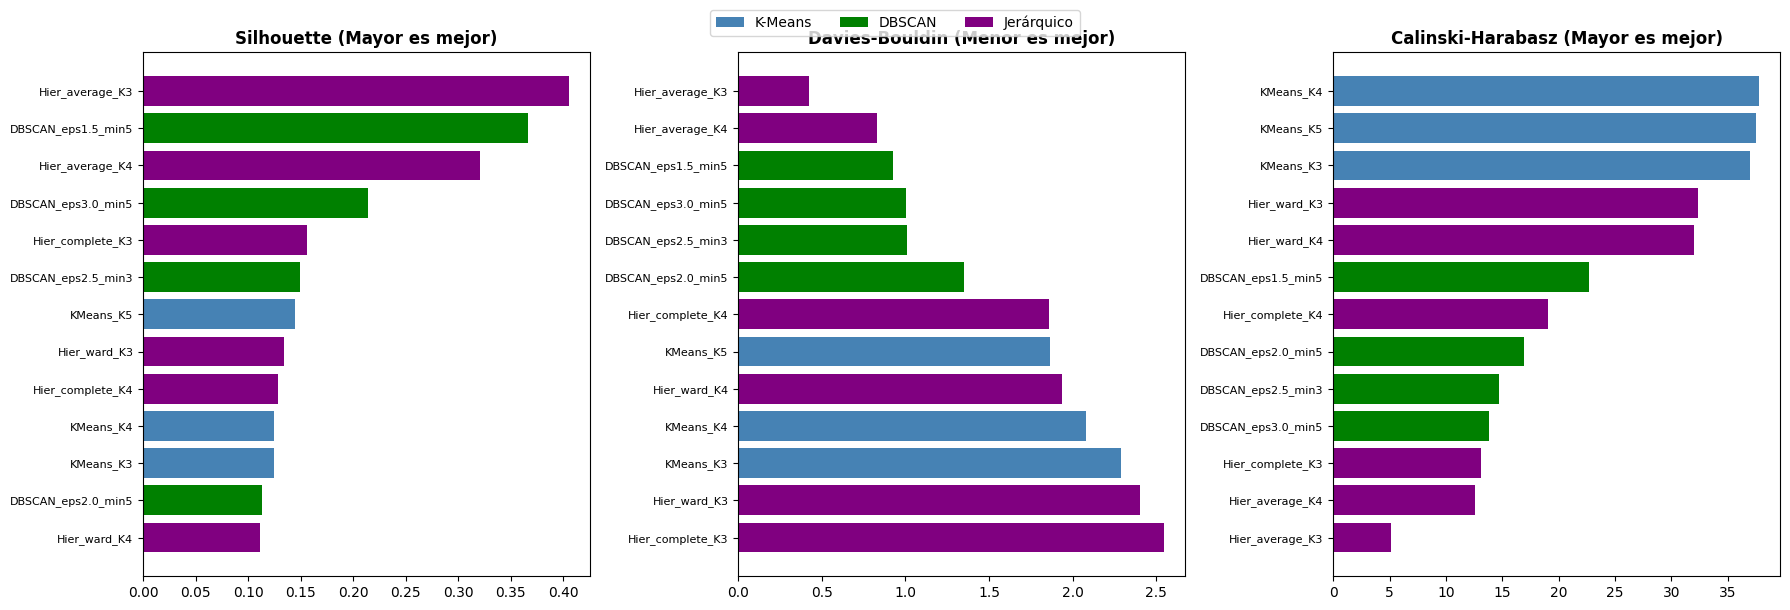

In [22]:
# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = {'K-Means': 'steelblue', 'DBSCAN': 'green', 'Jerárquico': 'purple'}

df_sorted = df_resultados.sort_values('Silhouette', ascending=True)
bar_colors = [colors[a] for a in df_sorted['Algoritmo']]
axes[0].barh(range(len(df_sorted)), df_sorted['Silhouette'], color=bar_colors)
axes[0].set_yticks(range(len(df_sorted)))
axes[0].set_yticklabels(df_sorted['Modelo'], fontsize=8)
axes[0].set_title('Silhouette (Mayor es mejor)', fontweight='bold')

df_sorted = df_resultados.sort_values('Davies-Bouldin', ascending=False)
bar_colors = [colors[a] for a in df_sorted['Algoritmo']]
axes[1].barh(range(len(df_sorted)), df_sorted['Davies-Bouldin'], color=bar_colors)
axes[1].set_yticks(range(len(df_sorted)))
axes[1].set_yticklabels(df_sorted['Modelo'], fontsize=8)
axes[1].set_title('Davies-Bouldin (Menor es mejor)', fontweight='bold')

df_sorted = df_resultados.sort_values('Calinski-Harabasz', ascending=True)
bar_colors = [colors[a] for a in df_sorted['Algoritmo']]
axes[2].barh(range(len(df_sorted)), df_sorted['Calinski-Harabasz'], color=bar_colors)
axes[2].set_yticks(range(len(df_sorted)))
axes[2].set_yticklabels(df_sorted['Modelo'], fontsize=8)
axes[2].set_title('Calinski-Harabasz (Mayor es mejor)', fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[a], label=a) for a in colors]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout()
plt.savefig('10_comparacion_metricas.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

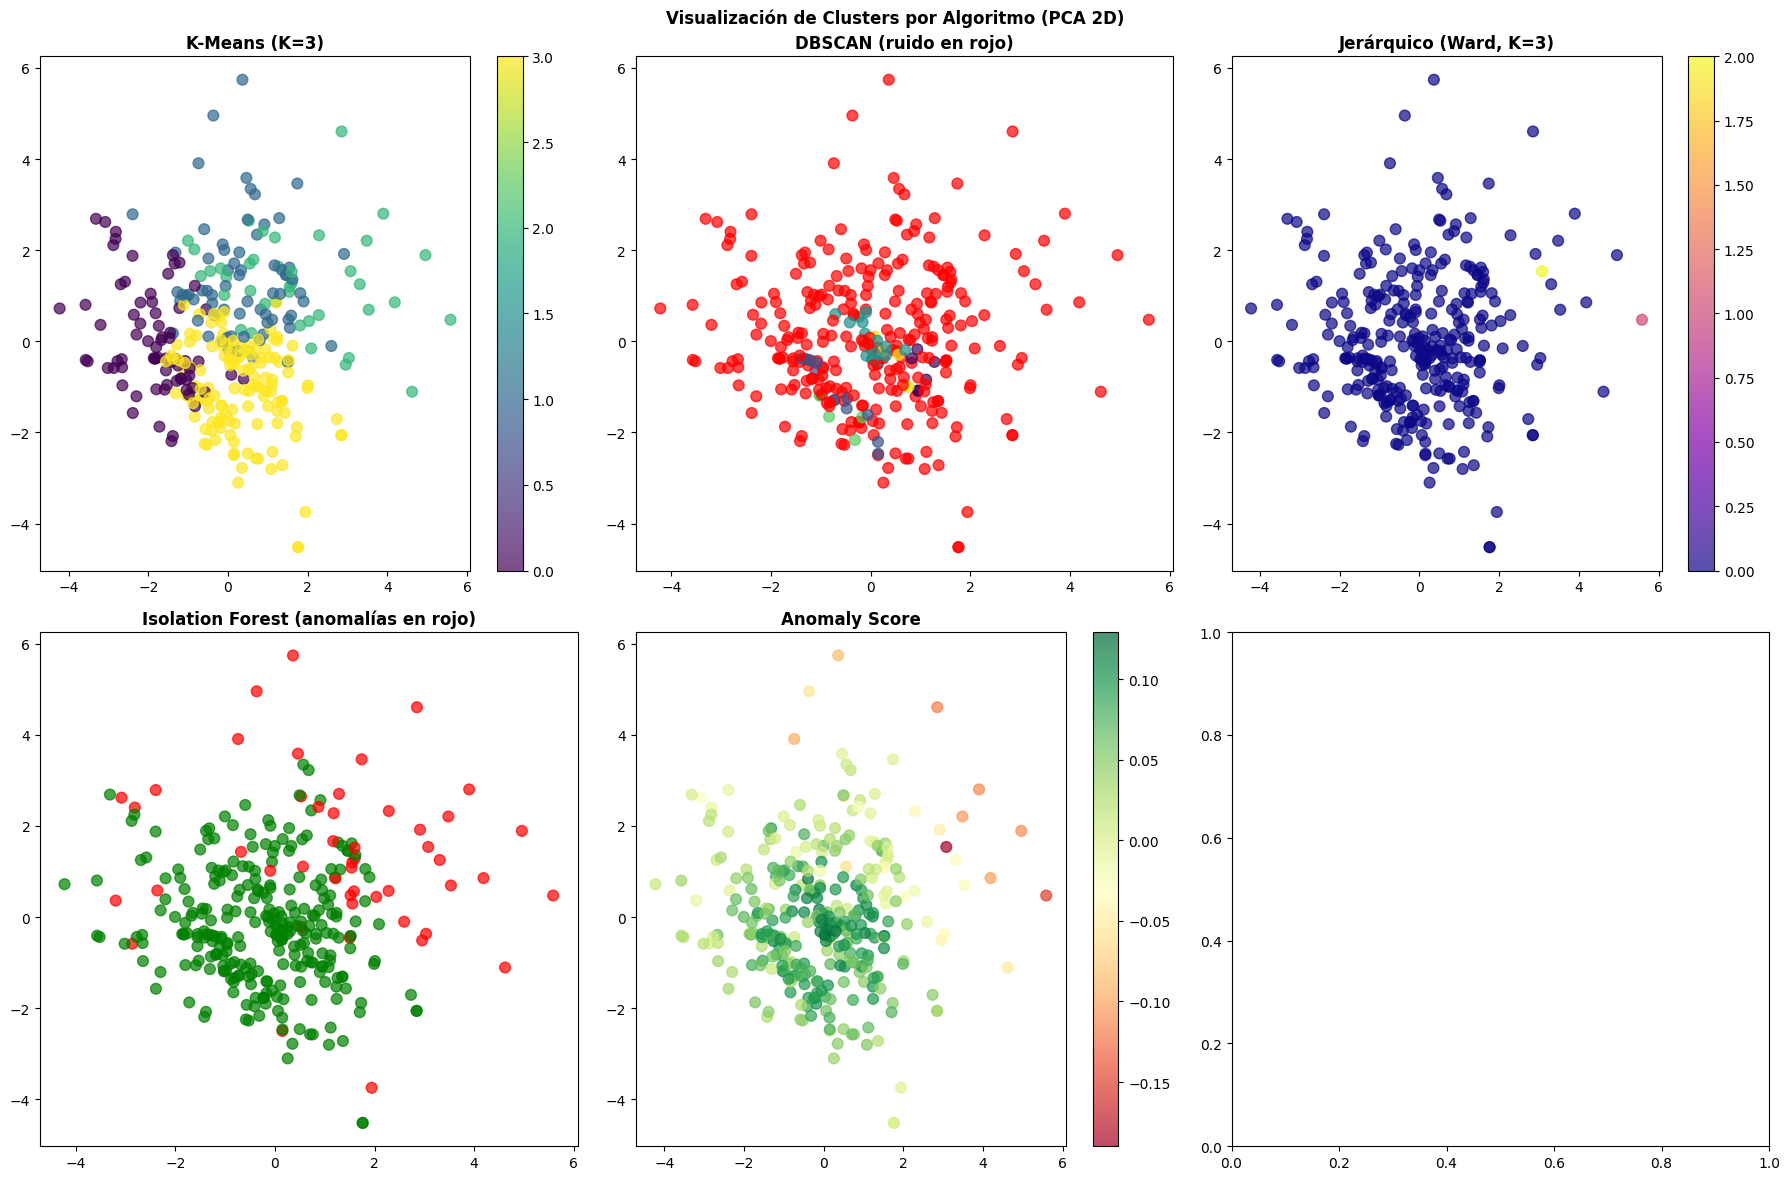

In [23]:
# Visualización de clusters
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

labels_km = kmeans_configs[f'KMeans_K4']['labels']
scatter = axes[0,0].scatter(X_pca[:,0], X_pca[:,1], c=labels_km, cmap='viridis', alpha=0.7, s=60)
axes[0,0].set_title(f'K-Means (K=3)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0,0])

labels_db = dbscan_configs['DBSCAN_eps1.5_min5']['labels']
colors_db = ['red' if x == -1 else plt.cm.viridis(x/max(1, labels_db.max())) for x in labels_db]
axes[0,1].scatter(X_pca[:,0], X_pca[:,1], c=colors_db, alpha=0.7, s=60)
axes[0,1].set_title('DBSCAN (ruido en rojo)', fontweight='bold')

labels_hier = hier_configs['Hier_average_K3']['labels']
scatter = axes[0,2].scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap='plasma', alpha=0.7, s=60)
axes[0,2].set_title('Jerárquico (Ward, K=3)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0,2])

labels_if = iforest_configs['IForest_cont0.15_est100']['labels']
colors_if = ['red' if x == -1 else 'green' for x in labels_if]
axes[1,0].scatter(X_pca[:,0], X_pca[:,1], c=colors_if, alpha=0.7, s=60)
axes[1,0].set_title('Isolation Forest (anomalías en rojo)', fontweight='bold')

scores_if = iforest_configs['IForest_cont0.15_est100']['scores']
scatter = axes[1,1].scatter(X_pca[:,0], X_pca[:,1], c=scores_if, cmap='RdYlGn', alpha=0.7, s=60)
axes[1,1].set_title('Anomaly Score', fontweight='bold')
plt.colorbar(scatter, ax=axes[1,1])

plt.suptitle('Visualización de Clusters por Algoritmo (PCA 2D)', fontweight='bold')
plt.tight_layout()
plt.savefig('11_visualizacion_clusters.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

**INTERPRETACIÓN Y CONCLUSIONES**

Distribución del Índice de Riesgo:
   Min: 0.027, Max: 0.923
   Media: 0.406, Mediana: 0.402

nivel_riesgo
Medio       195
Alto         65
Bajo         48
Muy Alto     12
Name: count, dtype: int64
Características por cluster (K-Means):
                costo_directo  gastos_generales  ratio_mano_de_obra_cd  ratio_materiales_cd  ratio_equipos_cd
cluster_kmeans                                                                                               
0                1.366572e+07      1.686803e+06                 0.3033               0.5010            0.0680
1                1.127540e+07      1.548699e+06                 0.2660               0.6552            0.0696
2                5.756292e+06      7.122096e+05                 0.2814               0.6067            0.0895
3                6.948463e+06      7.487679e+05                 0.3430               0.5836            0.0508


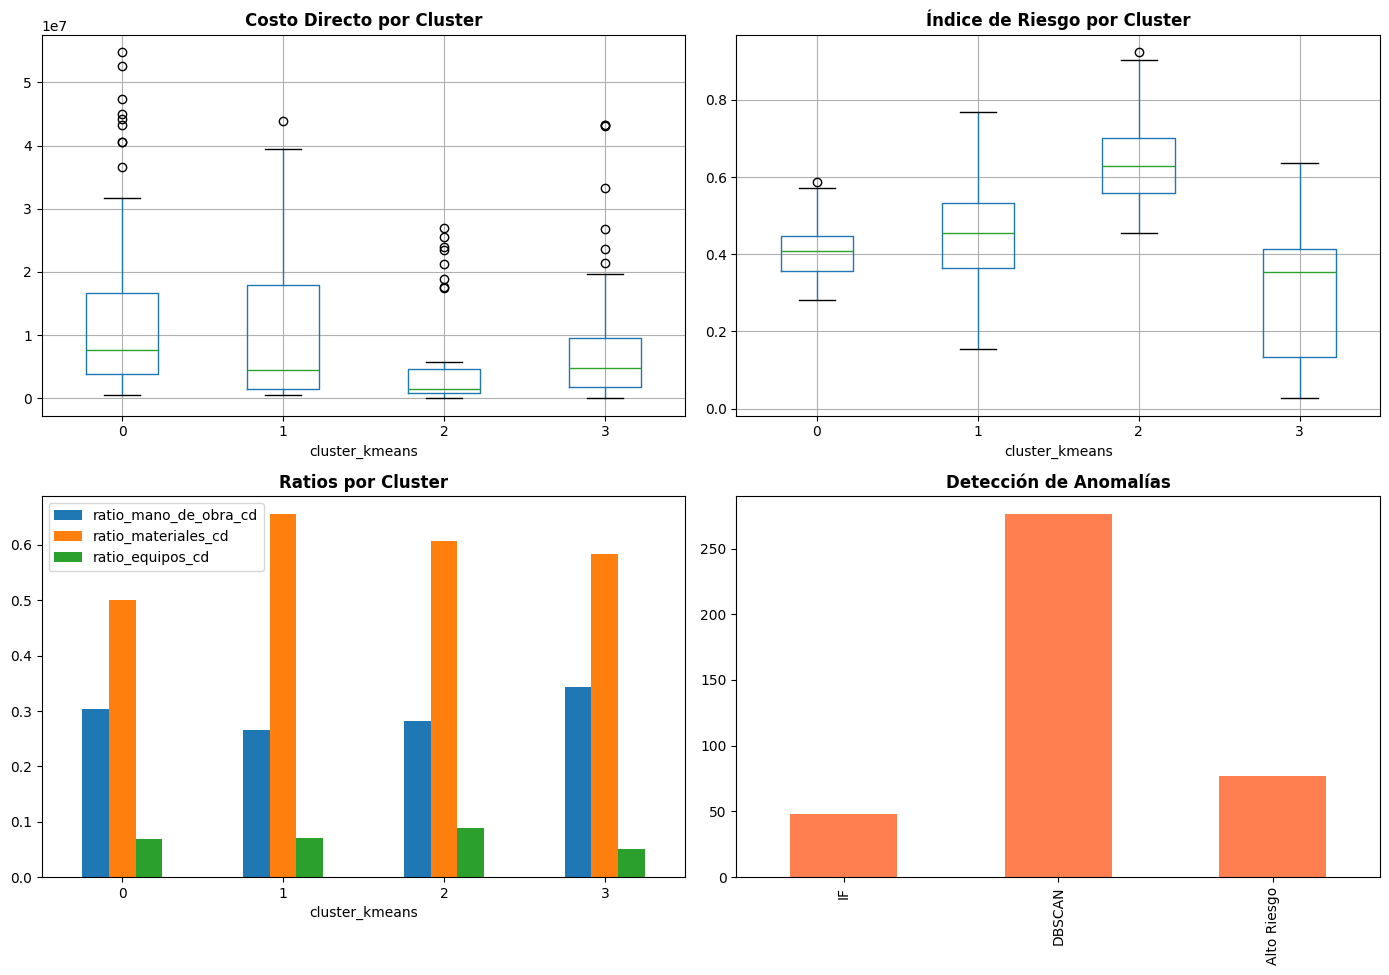

TOP 20 PROYECTOS DE MAYOR RIESGO:
         cui                                    lugar  costo_directo  indice_riesgo nivel_riesgo  anomalia_if  anomalia_dbscan
43   2237775                YUNGAR - CARHUAZ - ANCASH       43430.00       0.923479     Muy Alto            1                1
299  2032433                                 BARRANCA      510291.13       0.901939     Muy Alto            1                1
96   2676292                                 UTICYACU      608551.08       0.874751     Muy Alto            1                1
292  2596365                       CCOLLPACCASA-YAULI    18822932.43       0.831991     Muy Alto            1                1
46   2567582                  PURUS - PURUS - UCAYALI    17583665.13       0.815207     Muy Alto            1                1
85   2483346                                  MARCARA      936982.76       0.803232     Muy Alto            1                1
250  2599439                  HUALMAY - HUAURA - LIMA     1042675.54       0.

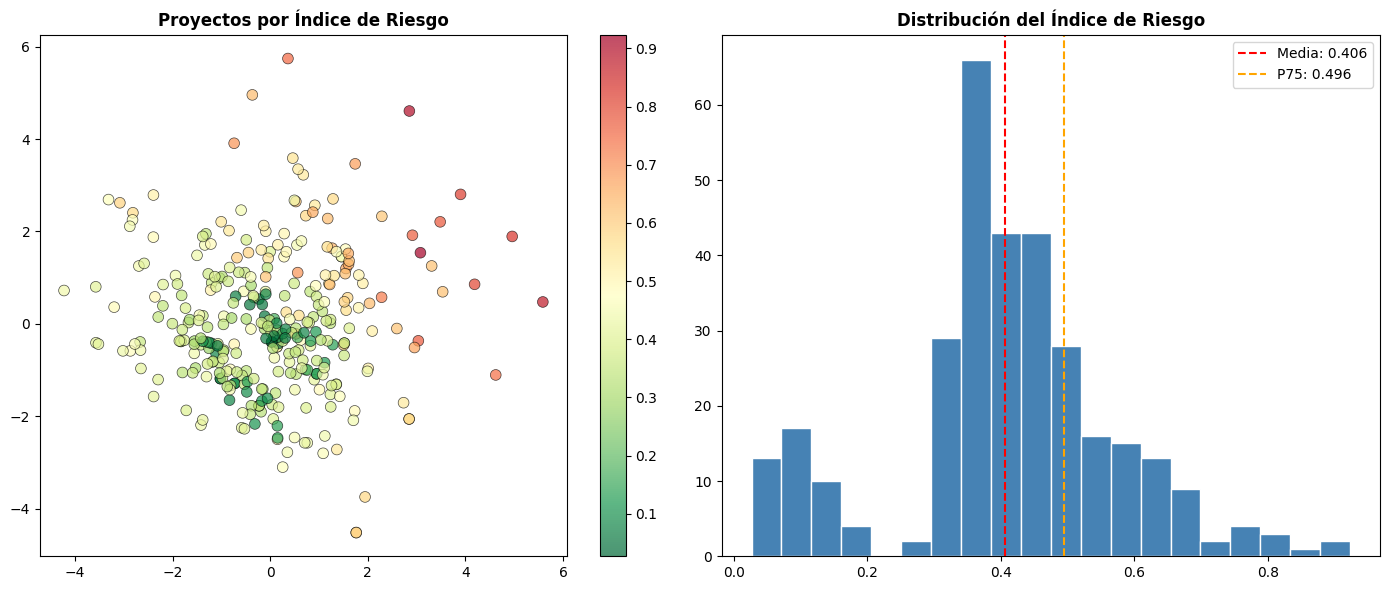

In [24]:
# Silhouette plot
labels_best = hier_configs[f'Hier_average_K3']['labels']
silhouette_vals = silhouette_samples(X_scaled, labels_best)
df_trabajo['silhouette_score'] = silhouette_vals

# Asignar resultados
df_trabajo['cluster_kmeans'] = kmeans_configs[f'KMeans_K4']['labels']
df_trabajo['cluster_dbscan'] = dbscan_configs['DBSCAN_eps1.5_min5']['labels']
df_trabajo['cluster_hier'] = hier_configs['Hier_average_K3']['labels']
df_trabajo['anomalia_if'] = (iforest_configs['IForest_cont0.15_est100']['labels'] == -1).astype(int)
df_trabajo['score_anomalia'] = iforest_configs['IForest_cont0.15_est100']['scores']
df_trabajo['anomalia_dbscan'] = (df_trabajo['cluster_dbscan'] == -1).astype(int)

# Índice de riesgo compuesto
scaler_risk = MinMaxScaler()
risk_if = 1 - scaler_risk.fit_transform(df_trabajo['score_anomalia'].values.reshape(-1,1)).flatten()
risk_dbscan = df_trabajo['anomalia_dbscan'].values
risk_sil = 1 - scaler_risk.fit_transform(silhouette_vals.reshape(-1,1)).flatten()
centroids = kmeans_configs[f'KMeans_K4']['model'].cluster_centers_
distances = np.array([np.linalg.norm(X_scaled[i] - centroids[labels_best[i]]) for i in range(len(X_scaled))])
risk_dist = scaler_risk.fit_transform(distances.reshape(-1,1)).flatten()

df_trabajo['indice_riesgo'] = risk_if * 0.35 + risk_dbscan * 0.25 + risk_sil * 0.25 + risk_dist * 0.15
df_trabajo['nivel_riesgo'] = pd.cut(df_trabajo['indice_riesgo'], bins=[0, 0.3, 0.5, 0.7, 1.0], labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(f"Distribución del Índice de Riesgo:")
print(f"   Min: {df_trabajo['indice_riesgo'].min():.3f}, Max: {df_trabajo['indice_riesgo'].max():.3f}")
print(f"   Media: {df_trabajo['indice_riesgo'].mean():.3f}, Mediana: {df_trabajo['indice_riesgo'].median():.3f}")
print(f"\n{df_trabajo['nivel_riesgo'].value_counts()}")

# Características por cluster
vars_caract = ['costo_directo', 'gastos_generales', 'ratio_mano_de_obra_cd', 'ratio_materiales_cd', 'ratio_equipos_cd']
print("Características por cluster (K-Means):")
print(df_trabajo.groupby('cluster_kmeans')[vars_caract].mean().round(4).to_string())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_trabajo.boxplot(column='costo_directo', by='cluster_kmeans', ax=axes[0,0])
axes[0,0].set_title('Costo Directo por Cluster', fontweight='bold')
df_trabajo.boxplot(column='indice_riesgo', by='cluster_kmeans', ax=axes[0,1])
axes[0,1].set_title('Índice de Riesgo por Cluster', fontweight='bold')
df_trabajo.groupby('cluster_kmeans')[['ratio_mano_de_obra_cd', 'ratio_materiales_cd', 'ratio_equipos_cd']].mean().plot(kind='bar', ax=axes[1,0], rot=0)
axes[1,0].set_title('Ratios por Cluster', fontweight='bold')
pd.DataFrame({'IF': df_trabajo['anomalia_if'].sum(), 'DBSCAN': df_trabajo['anomalia_dbscan'].sum(), 
              'Alto Riesgo': (df_trabajo['nivel_riesgo'].isin(['Alto', 'Muy Alto'])).sum()}, index=['Conteo']).T.plot(kind='bar', ax=axes[1,1], legend=False, color=['coral', 'steelblue', 'green'])
axes[1,1].set_title('Detección de Anomalías', fontweight='bold')
plt.suptitle('')
plt.tight_layout()
plt.savefig('12_caracteristicas_clusters.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# Top proyectos de riesgo
print("TOP 20 PROYECTOS DE MAYOR RIESGO:")
cols_mostrar = ['cui', 'lugar', 'costo_directo', 'indice_riesgo', 'nivel_riesgo', 'anomalia_if', 'anomalia_dbscan']
print(df_trabajo.nlargest(20, 'indice_riesgo')[cols_mostrar].to_string())

# Visualización final
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
scatter = axes[0].scatter(X_pca[:,0], X_pca[:,1], c=df_trabajo['indice_riesgo'], cmap='RdYlGn_r', alpha=0.7, s=60, edgecolor='black', linewidth=0.5)
axes[0].set_title('Proyectos por Índice de Riesgo', fontweight='bold')
plt.colorbar(scatter, ax=axes[0])
axes[1].hist(df_trabajo['indice_riesgo'], bins=20, color='steelblue', edgecolor='white')
axes[1].axvline(df_trabajo['indice_riesgo'].mean(), color='red', linestyle='--', label=f"Media: {df_trabajo['indice_riesgo'].mean():.3f}")
axes[1].axvline(df_trabajo['indice_riesgo'].quantile(0.75), color='orange', linestyle='--', label=f"P75: {df_trabajo['indice_riesgo'].quantile(0.75):.3f}")
axes[1].set_title('Distribución del Índice de Riesgo', fontweight='bold')
axes[1].legend()
plt.tight_layout()
plt.savefig('13_indice_riesgo_final.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

In [25]:
n_alto = len(df_trabajo[df_trabajo['nivel_riesgo'].isin(['Alto', 'Muy Alto'])])
n_medio = len(df_trabajo[df_trabajo['nivel_riesgo'] == 'Medio'])
n_bajo = len(df_trabajo[df_trabajo['nivel_riesgo'] == 'Bajo'])

print(f"""RESULTADOS:
 • Alto/Muy Alto Riesgo: {n_alto} proyectos
 • Riesgo Medio: {n_medio} proyectos
 • Bajo Riesgo: {n_bajo} proyectos
""")

# Exportar
cols_exp = ['cui', 'fecha', 'lugar', 'costo_directo', 'cluster_kmeans', 'cluster_kmedoids', 
            'cluster_dbscan', 'cluster_hier', 'anomalia_if', 'anomalia_dbscan', 'score_anomalia',
            'indice_riesgo', 'nivel_riesgo', 'silhouette_score']
cols_exp = [c for c in cols_exp if c in df_trabajo.columns]
df_trabajo[cols_exp].sort_values('indice_riesgo', ascending=False).to_csv('resultado_analisis_sobrecostos.csv', index=False)
print("✅ Archivo: resultado_analisis_sobrecostos.csv")

df_trabajo.groupby('cluster_kmeans').agg({'costo_directo': ['mean', 'count'], 'indice_riesgo': 'mean', 
                                          'anomalia_if': 'sum', 'anomalia_dbscan': 'sum'}).round(2).to_csv('resumen_clusters.csv')
print("✅ Archivo: resumen_clusters.csv")

df_resultados.to_csv('comparacion_modelos.csv', index=False)
print("✅ Archivo: comparacion_modelos.csv")

RESULTADOS:
 • Alto/Muy Alto Riesgo: 77 proyectos
 • Riesgo Medio: 195 proyectos
 • Bajo Riesgo: 48 proyectos

✅ Archivo: resultado_analisis_sobrecostos.csv
✅ Archivo: resumen_clusters.csv
✅ Archivo: comparacion_modelos.csv
